# 지난 내용 복습

저번 시간 내용은 전부 그래프 그리는 내용이라서,  
그냥 7주차 내용 복습  
  
메서드 오버라이딩 귀찮아서 그냥 생략

In [1]:
import numpy as np
from typing import Tuple, List
import weakref
import contextlib


class Config:
    enable_backprop = True

@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, value)
    try:
        yield
    finally:
        setattr(Config, old_value)

def no_grad():
    return using_config("enable_backprop", False)

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise ValueError(f"{type(data)}는 지원하지 않습니다.")
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0
        self.name = name

    def set_creator(self, f):
        self.creator = f
        self.generation = f.generation + 1

    def clean_grad(self):
        self.grad = None

    @property
    def size(self):
        return self.data.size
    
    @property
    def len(self):
        return len(self.data)
    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def dtype(self):
        return self.data.dtype
    
    @property
    def ndim(self):
        return self.data.ndim
    
    def __repr__(self):
        if self.data is None:
            return "Variable(None)"
        #p = str(self.data).replace('\n', '\n' + ' '*9)
        #return "Variable(" + p + ")"
        return str(self.data).replace('array', 'Variable')

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        seen_set = set()
        funcs = []

        def add_func(f):
            if f not in seen_set:
                seen_set.add(f)
                funcs.append(f)
            funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            xs, gys = f.inputs, [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = gxs,

            for x, gx in zip(xs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
                
                if x.creator is not None:
                    add_func(x.creator)
                
            if not retain_grad:
                ys = f.outputs
                for y in ys:
                    y().clean_grad()

class Function:
    def __call__(self, *inputs:List[Variable]):
        xs = [input.data for input in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = ys,
        outputs = [Variable(as_array(y)) for y in ys]
        
        if Config.enable_backprop:
            self.generation = 0
            for input in inputs:
                self.generation = max(self.generation, input.generation)
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, x:np.array):
        return NotImplementedError()
    
    def backward(self, gy:np.array):
        return NotImplementedError()
    
class Exp(Function):
    def forward(self, x:np.array) -> np.array:
        return np.exp(x)
    
    def backward(self, gy:np.array) -> np.array:
        return gy * np.exp(self.inputs[0].data)
    
class Square(Function):
    def forward(self, x:np.array) -> np.array:
        return x ** 2
    
    def backward(self, gy:np.array) -> np.array:
        return gy * 2 * self.inputs[0].data
    
class Add(Function):
    def forward(self, x1:np.array, x0:np.array) -> np.array:
        return x0 + x1
    
    def backward(self, gy:np.array) -> Tuple[np.array, np.array]:
        return gy, gy
    
def exp(x):
    return Exp()(x)

def square(x):
    return Square()(x)

def add(x0, x1):
    return Add()(x0, x1)


In [2]:
x = Variable(np.array([[1,2,],[3,4]]))
a = square(x)
y = add(square(a), square(a))
y.backward(retain_grad=False)
print(y.data)
print(y.grad)
print(x.grad)
print(x)

[[  2  32]
 [162 512]]
None
[[  8  64]
 [216 512]]
[[1 2]
 [3 4]]


# 이번주에는 총 2가지를 배운다 (step30~36)
1. 고차 미분 

# 1. 고차 미분
  
지금까지는 1차 미분만 진행했다.  
2, 3, ... n차 미분도 구현해보자.  
  
방법은 간단하다. 지금까지 grad를 np.array로 저장했는데, 이 또한 variable로 저장하면, backprop이 자연스럽게 가능해진다.  
  
추가적으로 functions.py에 sin, cos을 구현했는데, 별 다를 것 없다. 

In [3]:
###### core.py ######
import numpy as np
import weakref
import contextlib
from typing import List, Tuple


class Config:
    enable_backprop = True

def as_array(data):
    if np.isscalar(data):
        return np.array(data)
    return data

def as_varialbe(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)

@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)

def no_grad():
    return using_config("enable_backprop", False)

class Variable:
    def __init__(self, data:np.array, name=None):
        if not data.any():
            if not isinstance(data, np.ndarray):
                raise TypeError(f"{type(data)}은(는) 지원하지 않습니다.")
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0
        self.name = name

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False, create_graph=False):
        if self.grad is None:
            self.grad = Variable(np.ones_like(self.data))

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            xs, ys = f.inputs, f.outputs
            gys = [y().grad for y in ys]

            with using_config("enable_backprop", create_graph):
                gxs = f.backward(*gys)
                if not isinstance(gxs, tuple):
                    gxs = gxs,

                for x, gx in zip(xs, gxs):
                    if x.grad is None:
                        x.grad = gx
                    else:
                        x. grad = x.grad + gx
                
                    if x.creator is not None:
                        add_func(x.creator)
                
                if not retain_grad:
                    for y in ys:
                        y().grad = None

    @property
    def size(self):
        return self.data.size
    
    @property
    def dtype(self):
        return self.data.dtype
    
    @property
    def ndim(self):
        return self.data.ndim
    
    @property
    def shape(self):
        return self.data.shape
    
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        if self.data is None:
            return "variable(None)"
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ")"
    
    def __mul__(self, other):
        return mul(self, other)
    
    def __add__(self, other):
        return add(self, other)
    
    def __rmul__(self, other):
        return mul(other, self)
    
    def __radd__(self, other):
        return add(other, self)
    
    def __neg__(self):
        return neg(self)
    
    def __sub__(self, other):
        return sub(self, other)
    
    def __rsub__(self, other):
        return sub(other, self)
    
    def __truediv__(self, other):
        return div(self, other)
    
    def __rtruediv__(self, other):
        return div(other, self)
    
    def __pow__(self, c):
        return pow(self, c)


class Function:
    def __call__(self, *inputs:List[Variable]):
        inputs = [as_varialbe(as_array(input)) for input in inputs]

        xs = [input.data for input in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = ys,
        outputs = [Variable(as_array(y)) for y in ys]
        
        if Config.enable_backprop:
            self.generation = max([input.generation for input in inputs])
            for output in outputs:
                output.set_creator(self)
            self.outputs = [weakref.ref(output) for output in outputs]
            self.inputs = inputs
            
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, x):
        return NotImplementedError()
    
    def backward(self, gy):
        return NotImplementedError()
    
class Add(Function):
    def forward(self, x0, x1):
        #x1 = as_array(x1)
        return x0 + x1,

    def backward(self, gy):
        return gy, gy
    
class Mul(Function):
    def forward(self, x0, x1):
        #x1 = as_array(x1)
        return x0 * x1
    
    def backward(self, gy):
        return gy * self.inputs[1], gy * self.inputs[0]
    
class Neg(Function):
    def forward(self, x):
        return -x
    
    def backward(self, gy):
        return -gy
    
class Sub(Function):
    def forward(self, x0, x1):
        return x0 - x1
    
    def backward(self, gy):
        return gy, -gy
    
class Div(Function):
    def forward(self, x0, x1):
        return x0 / x1
    
    def backward(self, gy):
        return gy / self.inputs[1], -gy * self.inputs[0] / (self.inputs[1] ** 2)
    
class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        return x ** self.c
    
    def backward(self, gy):
        return gy * self.c * self.inputs[0] ** (self.c - 1)

def add(x0, x1):
    return Add()(x0, x1)

def mul(x0, x1):
    return Mul()(x0, x1)

def neg(x):
    return Neg()(x)

def sub(x0, x1):
    return Sub()(x0, x1)

def div(x0, x1):
    return Div()(x0, x1)

def pow(x, c):
    return Pow(c)(x)

def setup_variable():
    Variable.__add__ = add
    Variable.__radd__ = add
    Variable.__mul__ = mul
    Variable.__rmul__ = mul
    Variable.__neg__ = neg
    Variable.__sub__ = sub
    Variable.__rsub__ = sub
    Variable.__truediv__ = div
    Variable.__rtruediv__ = div
    Variable.__pow__ = pow


In [4]:
###### functions.py ######
import numpy as np
from dezero.core import Function

class Sin(Function):
    def forward(self, x):
        return np.sin(x)
    
    def backward(self, gy):
        return gy * cos(self.inputs[0])
    
class Cos(Function):
    def forward(self, x):
        return np.cos(x)
    
    def backward(self, gy):
        return gy * -sin(self.inputs[0])
    
class Exp(Function):
    def forward(self, x):
        return np.exp(x)
    
    def backward(self, gy):
        return gy * np.exp(self.inputs[0])
    
class Square(Function):
    def forward(self, x):
        return x ** 2
    
    def backward(self, gy):
        return gy * 2 * self.inputs[0]
    
class Tanh(Function):
    def forward(self, x):
        return np.tanh(x)
    
    def backward(self, gy):
        return gy * (1 - self.outputs[0]() * self.outputs[0]())
    
def exp(x):
    return Exp()(x)

def square(x):
    return Square()(x)

def sin(x):
    return Sin()(x)

def cos(x):
    return Cos()(x)

def tanh(x):
    return Tanh()(x)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from dezero.core import Variable
import dezero.functions as F

In [7]:
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i,x)
    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True)
    gx = x.grad

    x.cleargrad()
    gx.backward()
    gx2 = x.grad
    #print(gx, gx2)

    x.data -= gx.data / gx2.data

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


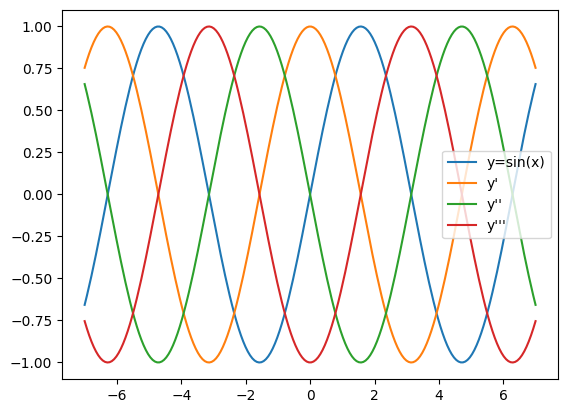

In [8]:
x = Variable(np.linspace(-7,7,200))
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data]

for i in range(3):
    logs.append(x.grad.data)
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

labels = ['y=sin(x)', "y'", "y''", "y'''"]
for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend()
plt.show()